## Importing Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline 

## Data Cleaning

In [2]:
data = pd.read_csv('Pokemon.csv')

In [3]:
data.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


In [4]:
data.shape

(800, 13)

In [5]:
# Removing irrelevant features(# and Name) and features with Nan values(Type 2)
data = data.drop(['#','Type 2','Name'],axis='columns')

In [6]:
data.head(10)

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,318,45,49,49,65,65,45,1,False
1,Grass,405,60,62,63,80,80,60,1,False
2,Grass,525,80,82,83,100,100,80,1,False
3,Grass,625,80,100,123,122,120,80,1,False
4,Fire,309,39,52,43,60,50,65,1,False
5,Fire,405,58,64,58,80,65,80,1,False
6,Fire,534,78,84,78,109,85,100,1,False
7,Fire,634,78,130,111,130,85,100,1,False
8,Fire,634,78,104,78,159,115,100,1,False
9,Water,314,44,48,65,50,64,43,1,False


In [7]:
data.Legendary.value_counts()

False    735
True      65
Name: Legendary, dtype: int64

It is clear that it is imbalanced dataset. Our model will fail to predict True values and memorizes on False values. So we need to make this dataset as balanced dataset.

In [8]:
legendaryPokemon = data.loc[data['Legendary']==True]
legendaryPokemon = legendaryPokemon.append(legendaryPokemon.append(legendaryPokemon))
bal_data = data.append(legendaryPokemon.append(legendaryPokemon.append(legendaryPokemon)))

So, what I did was I performed oversampling of True values (multiple times) in Legendary column and appended it to our original dataset

In [9]:
# mapping true and false to 1 and 0 respectively
bal_data['Legendary'] = bal_data.Legendary.map({False:0,True:1})

## Data Preprocessing

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
col_trans = make_column_transformer(
            (OneHotEncoder(),['Type 1','Generation']),
            (StandardScaler(),['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']),
            remainder = 'passthrough')

In [11]:
df = bal_data

## Train Test Split

In [12]:
from sklearn.model_selection import train_test_split
X = df.drop(['Legendary'], axis = 1)
y = df['Legendary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [13]:
col_trans.fit_transform(X_train)

<1108x31 sparse matrix of type '<class 'numpy.float64'>'
	with 9972 stored elements in Compressed Sparse Row format>

## Classification Models

### 1. Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
logreg = LogisticRegression(solver='lbfgs')
pipe = make_pipeline(col_trans,logreg)

In [15]:
from sklearn.model_selection import cross_val_score
print('Accuracy score on Train data: {}'.format(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()*100))

Accuracy score on Train data: 96.6637729180594


In [16]:
pipe = make_pipeline(col_trans,logreg)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
from sklearn import metrics
print('Accuracy score on Test data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy score on Test data: 96.75090252707581


### 2. K Nearest Neighbors Classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn_scores = []
for k in range(1,31):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    pipe = make_pipeline(col_trans,knn_classifier)
    knn_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

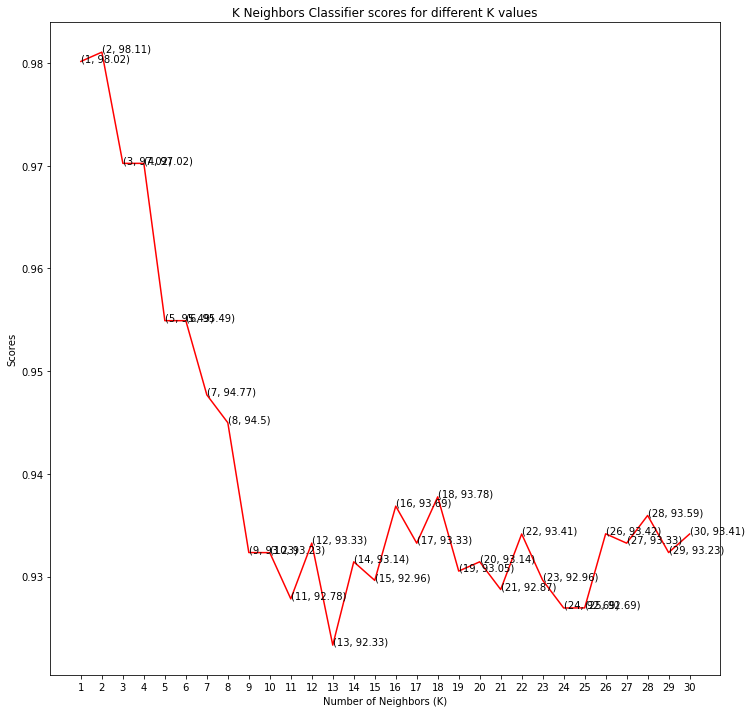

In [18]:
plt.figure(figsize=(12,12))
plt.plot([k for k in range(1, 31)], knn_scores, color = 'red')
for i in range(1,31):
    plt.text(i, knn_scores[i-1], (i, round(knn_scores[i-1]*100,2)))
plt.xticks([i for i in range(1, 31)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [19]:
print('Accuracy score on Train data: {}'.format(knn_scores[1]*100))

Accuracy score on Train data: 98.10685591745998


In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors = 2)
pipe = make_pipeline(col_trans,knn_classifier)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy score on Test Data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy score on Test Data: 98.19494584837545


### 3. Support Vector Classifier (SVC)

In [21]:
from sklearn.svm import SVC
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    pipe = make_pipeline(col_trans,svc_classifier)
    svc_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Support Vector Classifier scores for different kernels')

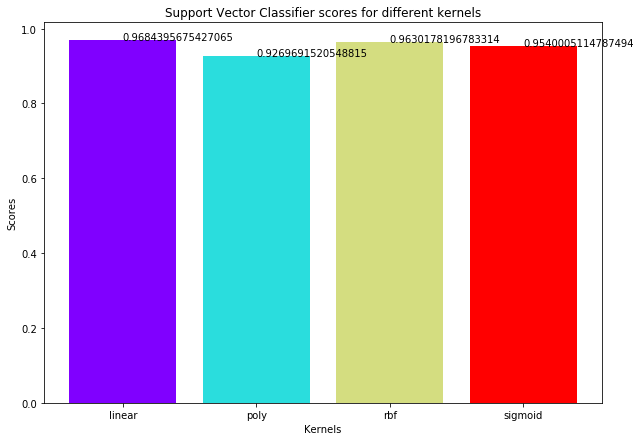

In [22]:
from matplotlib.cm import rainbow
import numpy as np
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.figure(figsize=(10,7))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels')

In [23]:
print('Accuracy score on Train data: {}'.format(svc_scores[0]*100))

Accuracy score on Train data: 96.84395675427065


In [24]:
svc_classifier = SVC(kernel = 'linear')
pipe = make_pipeline(col_trans,svc_classifier)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy score on Test data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy score on Test data: 96.75090252707581


### 4. Decision Tree Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    pipe = make_pipeline(col_trans,dt_classifier)
    dt_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

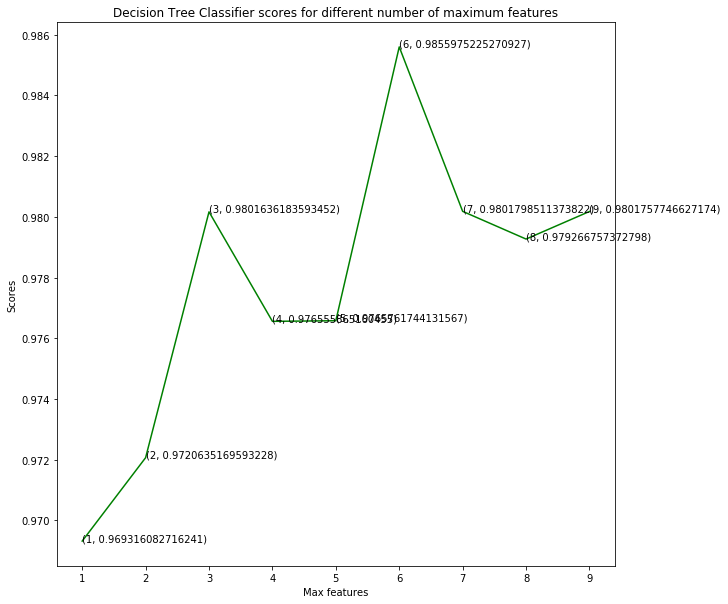

In [26]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

In [27]:
print('Accuracy score on Train data: {}'.format(dt_scores[5]*100))

Accuracy score on Train data: 98.55975225270926


In [28]:
dt_classifier = DecisionTreeClassifier(max_features = 6, random_state = 0)
pipe = make_pipeline(col_trans,dt_classifier)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy  score on Test data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy  score on Test data: 97.83393501805054


### 5. Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    pipe = make_pipeline(col_trans,rf_classifier)
    rf_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Random Forest Classifier scores for different number of estimators')

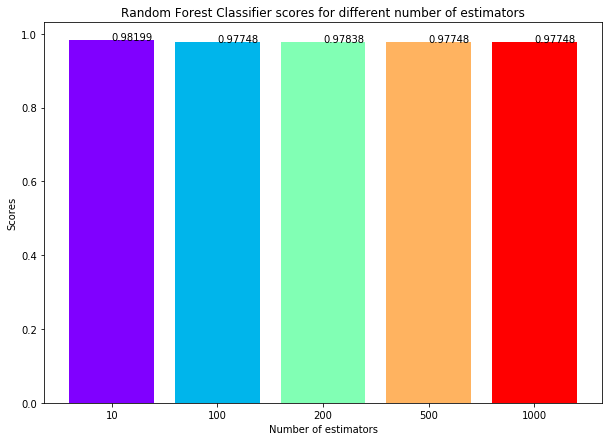

In [30]:
plt.figure(figsize=(10,7))
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], round(rf_scores[i],5))
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

In [31]:
print('Accuracy score on Train data: {}'.format(rf_scores[0]*100))

Accuracy score on Train data: 98.1993882363178


In [32]:
rf_classifier = RandomForestClassifier(n_estimators = 10, random_state = 0)
pipe = make_pipeline(col_trans,rf_classifier)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy score on Test data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy score on Test data: 97.47292418772562
